In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

In [2]:
os.getcwd()

'f:\\School\\Masinope\\grid_congestion_manager'

In [3]:
# os.chdir('/home/joonas/Documents/grid_congestion_manager')
os.chdir('/Users/ilmaruduste/School/Masinõpe') #Ilmar Mac
# os.chdir('E:\ML\grid_congestion_manager') #Sille PC

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/Users/ilmaruduste/School/Masinõpe'

In [4]:
grid_load = pd.read_csv('grid_congestion_data/gridload.csv', index_col= [0])
grid_locations = pd.read_csv('grid_congestion_data/grid_locations.csv', index_col= [0])
ev_home = pd.read_csv('grid_congestion_data/ev_home_locations.csv', index_col= [0])
public_chargers = pd.read_csv('grid_congestion_data/public_chargers_locations.csv', index_col= [0])
ev_history = pd.read_csv('grid_congestion_data/ev_history.csv', index_col= [0])
cars = pd.read_csv('grid_congestion_data/ev_models.csv', index_col= [0])

### CLUSTERING

In [5]:
# find eucleidian distance between points (x1, y1) and (x2, y2)
def x_y_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2) 

# method adds closest grid cadaster to dataframe
def closest_grid_cadaster(location, grid):
    closest_grids = [] # list used to update dataframe later
    
    # iter over all locations
    for l in location.iterrows():
        # temp variables
        min_distance = None
        closest_grid = None
        
        # find distance from location l to all grids g
        for g in grid.iterrows():
            distance = x_y_distance(l[1].x, l[1].y, g[1].x, g[1].y)
            
            # if closer than previous closest grid, then overwrite
            if min_distance == None or distance < min_distance:
                min_distance = distance
                closest_grid = g[1].cadaster
                
        closest_grids.append(closest_grid)
    
    #update dataframe
    location.loc[:,"closest_grid_cadaster"] = closest_grids
    
closest_grid_cadaster(ev_home, grid_locations)
closest_grid_cadaster(public_chargers, grid_locations)

### SUBSTATION LOADS PROCESSING

In [7]:
#calculating baseloads

cadasters = grid_load['cadaster'].unique()
baseloads = dict()

for cadaster in cadasters: # lets make a empty dict with correct structure
    one_day_loads = np.zeros((24)) #24 hours in a day
    baseloads[cadaster] = one_day_loads

for index, row in grid_load.iterrows(): #insert correct elements into dict
    
    baseloads[row['cadaster']][row['time']-1] = row['baseload']


In [8]:
#make dict with different car model's chargning powers
charging_powers = dict()
for index, row in cars.iterrows():
    
    charging_powers[row['models']] = row['charge_power']

In [9]:
#make dict with loads from ev charging
ev_loads = dict()
for cadaster in cadasters: 
    one_day_loads = np.zeros((24)) #24 hours in a day
    ev_loads[cadaster] = one_day_loads

for index, row in ev_history.iterrows(): #scan over history
    if row['connected'] == True and row['charge_need'] != 0: #check if car is connected and needs charge
        
        cadaster_of_interest = row['cadaster'] #have to find out whats the closest substation for this cadaster
        for index, public_row in public_chargers.iterrows(): #scan public chargers
            if public_row['cadaster'] == cadaster_of_interest:
                ev_loads[public_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
             
                break     
        
        for index, home_row in ev_home.iterrows(): #scan home chargers
            if home_row['cadaster'] == cadaster_of_interest:
                ev_loads[home_row['closest_grid_cadaster']][row['time']-1] += charging_powers[row['model']]
               
                break

In [10]:
power_limits = dict()

for index, row in grid_locations.iterrows():
    power_limits[row['cadaster']] = row['max_current']

### LEGEND

In [11]:
#cadasters #all cadasters for substations
#baseloads #dictionary for baseloads for each substation (key: cadaster, value: 24 element array)
#ev_loads #dictionary for ev charging loads for each substation (key: cadaster, value: 24 element array)
#power_limits #dictionary for power limits for each substation (key: cadaster, value: 24 element array)

In [12]:
#79514:037:0108 on see lappes kadaster

### EXAMPLE

Making the dictionaries into a Pandas DataFrame so I can visualise it in PlotNine.

In [13]:
loads_dataframe = pd.DataFrame.from_dict([baseloads, power_limits]).T
ev_loads_dataframe = pd.DataFrame.from_dict([ev_loads, power_limits]).T
loads_dataframe.columns = ['baseloads','power_limit']
ev_loads_dataframe.columns = ['ev_loads','power_limit']

loads_dataframe = loads_dataframe.explode('baseloads')
ev_loads_dataframe = ev_loads_dataframe.explode('ev_loads')
loads_dataframe['ev_loads'] = ev_loads_dataframe['ev_loads']

hour_array = []
for i in range(1200):
    hour_array.append(i%24)
loads_dataframe['hour'] = hour_array

loads_dataframe = loads_dataframe.reset_index()
loads_dataframe.columns = ['cadaster', 'baseloads', 'power_limit', 'ev_loads', 'hour']

loads_dataframe.head()
# print(loads_dataframe.shape)

,cadaster,baseloads,power_limit,ev_loads,hour
0,79511:003:0022,98.9976,200,0,0
1,79511:003:0022,104.894,200,0,1
2,79511:003:0022,85.2187,200,0,2
3,79511:003:0022,98.9416,200,0,3
4,79511:003:0022,79.8893,200,0,4


In [14]:
loads_dataframe['baseloads'] = loads_dataframe['baseloads'].astype('float')
loads_dataframe['power_limit'] = loads_dataframe['power_limit'].astype('float')
loads_dataframe['ev_loads'] = loads_dataframe['ev_loads'].astype('float')

loads_dataframe.dtypes

cadaster        object
baseloads      float64
power_limit    float64
ev_loads       float64
hour             int64
dtype: object

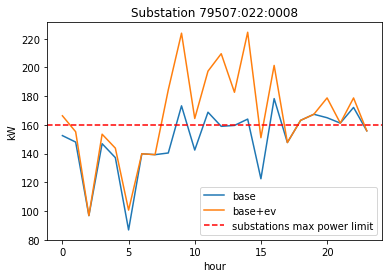

lol, see on alajaam on juba eos lappes


In [15]:
plt.plot(baseloads['79507:022:0008'], label = 'base')
plt.xlabel('hour')
plt.ylabel('kW')
plt.title('Substation 79507:022:0008')
plt.plot(baseloads['79507:022:0008']+ev_loads['79507:022:0008'], label = 'base+ev')
plt.axhline(y=power_limits['79507:022:0008'], color='r', linestyle='--',label = 'substations max power limit')
plt.legend()
plt.show()
print('lol, see on alajaam on juba eos lappes')

In [16]:
loads_dataframe['baseloads']

0        98.997612
1       104.894207
2        85.218661
3        98.941638
4        79.889267
           ...    
1195     52.634746
1196     52.214057
1197     42.459255
1198     41.250361
1199     54.524739
Name: baseloads, Length: 1200, dtype: float64

In [17]:
# plotnine.options requires another import. This is a minor inconvenience, but it gets the job done
import plotnine

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


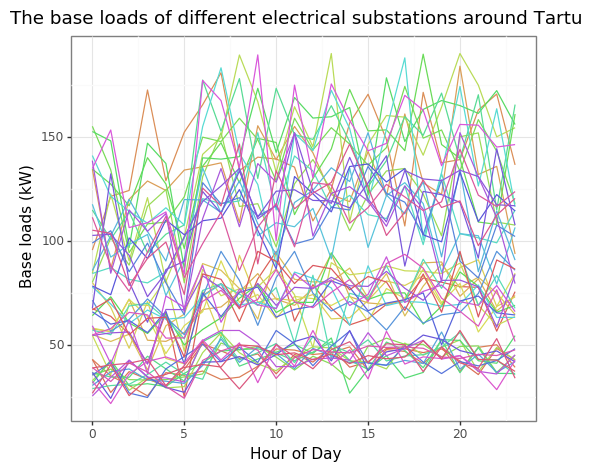

<ggplot: (-9223371917694255928)>

In [18]:

plotnine.options.figure_size = (6,5)

fig = (
    ggplot(data = loads_dataframe, mapping = aes(x = 'hour', color = 'cadaster')) + geom_line(mapping = aes(y='baseloads')) +
    theme_bw() + xlab('Hour of Day') + ylab('Base loads (kW)') + scale_color_discrete(guide=False) + ggtitle('The base loads of different electrical substations around Tartu') +
    theme(text=element_text(family="Helvetica"))
)
fig

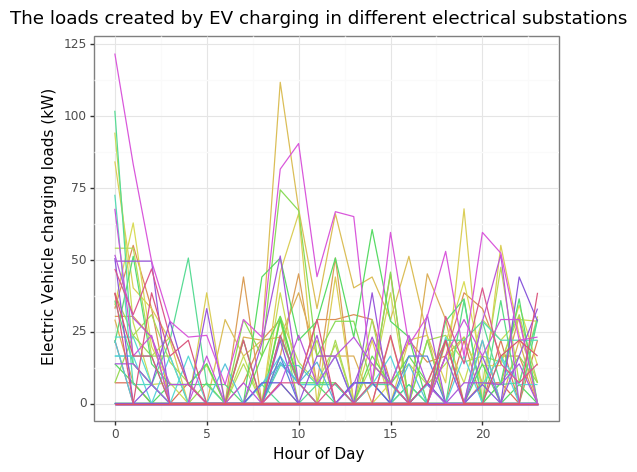

<ggplot: (-9223371917694115304)>

In [19]:

plotnine.options.figure_size = (6,5)

fig = (
    ggplot(data = loads_dataframe, mapping = aes(x = 'hour', color = 'cadaster')) + geom_line(mapping = aes(y='ev_loads')) +
    theme_bw() + xlab('Hour of Day') + ylab('Electric Vehicle charging loads (kW)') + scale_color_discrete(guide=False) + ggtitle('The loads created by EV charging in different electrical substations') +
    theme(text=element_text(family="Helvetica"))
)
fig

Calculating average loads in the whole dataframe. Also constructing a tall dataframe to experiment with ggplot visualisations.

In [19]:
avg_loads_dataframe = loads_dataframe.groupby('hour').mean().reset_index()
avg_loads_dataframe['combined_load'] = avg_loads_dataframe['baseloads'] + avg_loads_dataframe['ev_loads']
avg_loads_dataframe.head()

avg_loads_dataframe_tall = pd.melt(avg_loads_dataframe.drop(columns = ['power_limit'], axis=1), id_vars=['hour'], value_vars=['baseloads', 'ev_loads', 'combined_load'])

loads_order_dict = {'combined_load':2, 'baseloads':1, 'ev_loads':0}
avg_loads_dataframe_tall = avg_loads_dataframe_tall.sort_values(by=['variable'], key = lambda x: x.map(loads_order_dict))

avg_loads_dataframe_tall.head()


,hour,variable,value
35,11,ev_loads,6.554
26,2,ev_loads,9.938
27,3,ev_loads,4.898
28,4,ev_loads,3.456
29,5,ev_loads,3.458


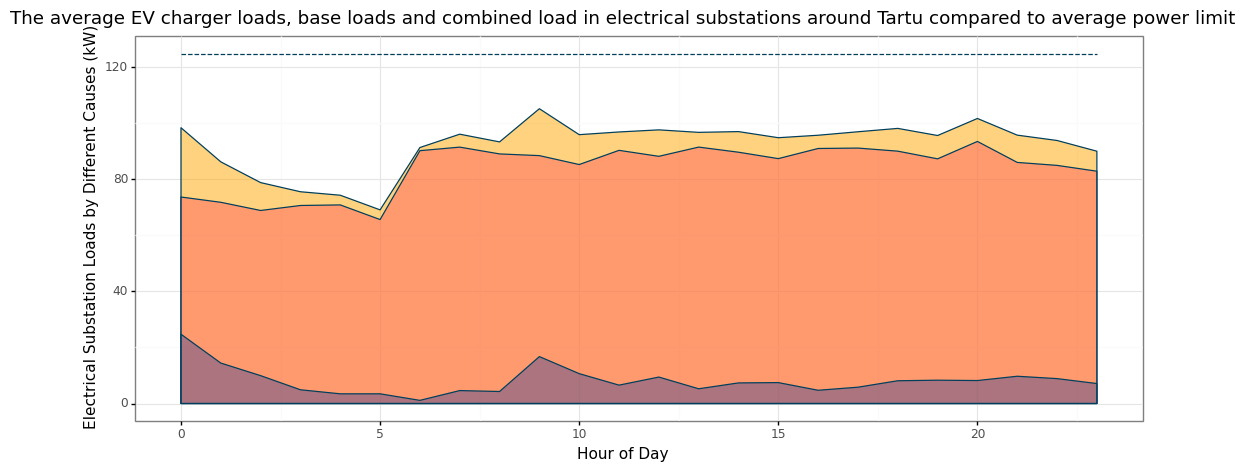

<ggplot: (8780020361709)>

In [20]:

plotnine.options.figure_size = (13,5)

fig = (
    ggplot(data = avg_loads_dataframe, mapping = aes(x = 'hour')) + 
    # geom_line(mapping = aes(y='ev_loads'), color="black") +
    # geom_line(mapping = aes(y='baseloads')) +
    # geom_line(mapping = aes(y='power_limit')) +
    geom_area(mapping = aes(y='combined_load'), color="#003f5c", fill = "#ffa600", alpha = 0.5) +
    geom_area(mapping = aes(y='baseloads'), color="#003f5c", fill="#ff6361", alpha = 0.5) +
    geom_area(mapping = aes(y='ev_loads'), color="#003f5c", fill="#58508d", alpha = 0.5) +
    # geom_area(mapping = aes(y='combined_load'), color="#1f4250", fill = "#f3ff82", alpha = 1) +
    # geom_area(mapping = aes(y='baseloads'), color="#1f4250", fill="#17b79c", alpha = 1) +
    # geom_area(mapping = aes(y='ev_loads'), color="#1f4250", fill="#1f4250", alpha = 1) +
    geom_line(mapping = aes(y='power_limit'), color="#003f5c", linetype = "dashed") +
    theme_bw() + xlab('Hour of Day') + ylab('Electrical Substation Loads by Different Causes (kW)') + scale_color_discrete(guide=False) + ggtitle('The average EV charger loads, base loads and combined load in electrical substations around Tartu compared to average power limit') + labs(color="Legend") + 
    theme(text=element_text(family="Helvetica"))
)
fig

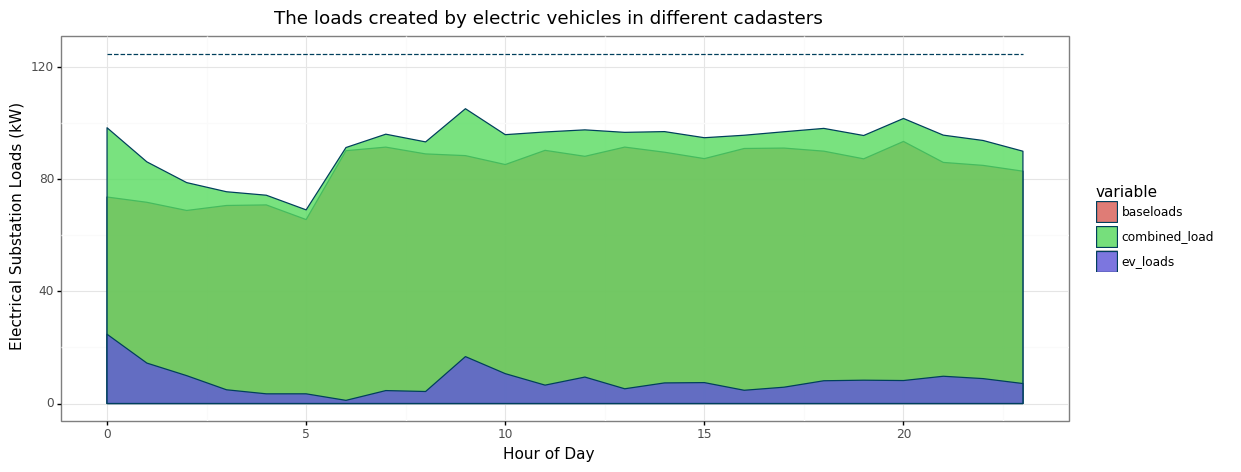

<ggplot: (8780022573045)>

In [21]:
plotnine.options.figure_size = (13,5)

fig = (
    ggplot(data = avg_loads_dataframe_tall, mapping = aes(x = 'hour')) + 
    geom_area(mapping = aes(y='value', fill = 'variable'), color="#003f5c", alpha = 0.8, position = position_dodge(width=0)) +
    geom_line(mapping = aes(y=124.8), color="#003f5c", linetype = "dashed") +
    theme_bw() + xlab('Hour of Day') + ylab('Electrical Substation Loads (kW)') + 
    #scale_fill_manual(breaks = ["combined_load", "baseloads", "ev_loads"],values = ['#ff6361', '#ffa600', '#58508d']) + 
    ggtitle('The loads created by electric vehicles in different cadasters') +
    theme(text=element_text(family="Helvetica"))
    )
fig

In [74]:
#remove substations with no conncetions
significant_substations = grid_locations[grid_locations['cadaster'].isin(ev_home['closest_grid_cadaster']) | grid_locations['cadaster'].isin(public_chargers['closest_grid_cadaster'])]

In [75]:
significant_substations.reset_index(inplace = True)

In [76]:
significant_substations = significant_substations.copy()

significant_substations['public_chargers'] = np.zeros((len(significant_substations),1))
significant_substations['home_chargers'] = np.zeros((len(significant_substations),1))

for index,row in public_chargers.iterrows():
    significant_substations.loc[significant_substations.cadaster == row['closest_grid_cadaster'],'public_chargers'] += 1
    
for index,row in ev_home.iterrows():
    significant_substations.loc[significant_substations.cadaster == row['closest_grid_cadaster'],'home_chargers'] += 1

In [77]:
#train/test split
from sklearn.model_selection import train_test_split

train, test = train_test_split(significant_substations, test_size=0.2, random_state=42, shuffle = True)

## MUDELI ANDMETE ETTEVALMISTUS

In [67]:
from sklearn import preprocessing

from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.models import load_model
from keras.layers import LeakyReLU

In [78]:
train = train.copy()
train.head()

,index,address,cadaster,latitude,longitude,x,y,max_current,public_chargers,home_chargers
24,138,"Juure, Jaamamõisa, Tartu linn, Tartu, Tartu li...",79301:001:0342,58.383253,26.764144,6474748.69,661646.72,100,0.0,1.0
16,15,"33, Viljandi mnt, Maarjamõisa, Tartu linn, Tar...",79502:019:0018,58.370127,26.689523,6473103.15,657342.63,60,2.0,5.0
8,193,"68a/3, Puiestee, Raadi-Kruusamäe, Tartu linn, ...",79512:032:0012,58.390462,26.727509,6475460.14,659468.49,160,1.0,0.0
15,168,"16a, Roosi, Ülejõe, Tartu linn, Tartu, Tartu l...",79514:014:0021,58.385042,26.730641,6474849.44,659676.18,160,1.0,4.0
12,59,"2, Juhan Liivi, Kesklinn, Tartu linn, Tartu, T...",79507:022:0008,58.378215,26.714904,6474067.16,658809.66,160,3.0,2.0


In [79]:
train.drop(['index','address','latitude','longitude','max_current'],axis= 'columns', inplace = True) #drop unnessesarcy

In [80]:
train.reset_index(inplace = True) #reset index

In [81]:
ev = pd.DataFrame.from_dict(ev_loads) #transform EV loads to dataframe

In [82]:
train = pd.merge(train, ev.T, right_index=True, left_on='cadaster') #join ev laods with train on cadaster


In [83]:
train

,index,cadaster,x,y,public_chargers,home_chargers,0,1,2,3,...,14,15,16,17,18,19,20,21,22,23
0,24,79301:001:0342,6474748.69,661646.72,0.0,1.0,7.2,7.2,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.2,7.2,0.0,0.0
1,16,79502:019:0018,6473103.15,657342.63,2.0,5.0,84.2,40.2,33.0,22.0,...,22.0,0.0,22.0,23.7,7.2,67.7,0.0,55.0,23.7,7.2
2,8,79512:032:0012,6475460.14,659468.49,1.0,0.0,0.0,0.0,0.0,0.0,...,7.2,0.0,0.0,7.2,0.0,0.0,0.0,0.0,0.0,0.0
3,15,79514:014:0021,6474849.44,659676.18,1.0,4.0,51.7,29.7,23.1,6.6,...,13.8,6.6,23.7,6.6,0.0,0.0,28.6,51.7,0.0,0.0
4,12,79507:022:0008,6474067.16,658809.66,3.0,2.0,13.8,7.2,0.0,6.6,...,60.5,28.6,23.1,0.0,0.0,0.0,13.8,0.0,6.6,0.0
5,32,79509:013:0018,6470765.10,658458.10,1.0,0.0,0.0,0.0,0.0,0.0,...,6.6,6.6,0.0,6.6,0.0,0.0,0.0,0.0,0.0,0.0
6,9,79517:025:0023,6470809.18,662517.67,1.0,5.0,46.8,30.9,46.8,23.1,...,7.2,7.2,0.0,0.0,30.3,13.8,40.2,13.8,7.2,13.8
7,19,79301:001:0667,6470565.41,661536.17,0.0,1.0,22.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22.0,0.0,22.0,0.0,22.0
8,0,79511:003:0022,6471601.92,659795.21,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,16.5,16.5,0.0,0.0,0.0,0.0,0.0,0.0
9,31,79517:053:0014,6472095.69,662802.05,2.0,2.0,38.5,0.0,38.5,16.5,...,0.0,23.7,0.0,7.2,22.0,0.0,0.0,0.0,0.0,38.5


## Tehisandmete genereerimine dashboardi jaoks

In [33]:
loads_dataframe.head()

from copy import deepcopy

synth_loads_dataframe = deepcopy(loads_dataframe)

grid_locations.head()

synth_loads_dataframe = pd.merge(synth_loads_dataframe, grid_locations,  on = 'cadaster').drop(['max_current'], axis=1)
synth_loads_dataframe.head()
# synth_loads_dataframe.shape

synth_loads_dataframe.to_csv('synth_loads_dataframe.csv', sep=';')

Siinkohal kasutan 'synth' andmetena tegelikult meile esialgselt antud andmestikku, aga ma lihtsalt teen selle selliseks kujuks, et ma saaksin seda dashboardi ehitamisel kasutada.